# Import Data

In [28]:
pip install emoji

In [29]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import time
import zipfile
import re
import string
import nltk
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from textblob import TextBlob

In [31]:
with zipfile.ZipFile("imdb-dataset-of-50k-movie-reviews.zip", "r") as zip_ref:
    zip_ref.extractall("data")

dataset = pd.read_csv("data/IMDB Dataset.csv")

In [32]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [33]:
dt = dataset.head(10000).copy()

In [34]:
dt.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [35]:
dt.shape

(10000, 2)

In [36]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     10000 non-null  object
 1   sentiment  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


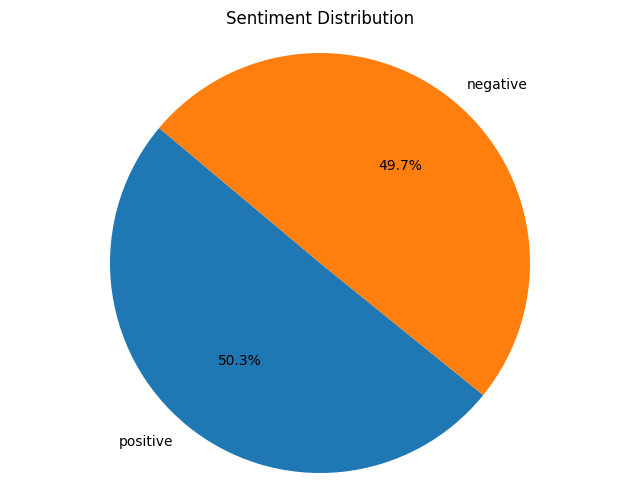

In [37]:
dt['sentiment'].value_counts()
# Get the value counts of sentiment
sentiment_counts = dt['sentiment'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

# Data cleanning and Preprocessing

In [38]:
#find null value row
dt.isnull().sum()

review       0
sentiment    0
dtype: int64

The Data dont have any null value, so we dont need to drop the null rows.


---


In [39]:
# Find duplicate row count
print(f'duplicate row count :{dt.duplicated().sum()}\n')

# Check for duplicate rows in the DataFrame
duplicate_mask = dt.duplicated()

# Get the duplicate rows into another DataFrame
duplicate_rows = dt[duplicate_mask]

# Display the duplicate rows
print("Duplicate Rows:")
print(duplicate_rows['review'],'\n')

print("First Row Review Value:")
print(duplicate_rows.iloc[0]['review'])

duplicate row count :17

Duplicate Rows:
3537    Quite what the producers of this appalling ada...
3769    My favourite police series of all time turns t...
4391    Beautiful film, pure Cassavetes style. Gena Ro...
6352    If you liked the Grinch movie... go watch that...
6479    I want very much to believe that the above quo...
6672    Sigh. I'm baffled when I see a short like this...
7221    I have always been a huge fan of "Homicide: Li...
7222    There are plenty of comments already posted sa...
7425    The movie was excellent, save for some of the ...
7555    This movie has made me upset! When I think of ...
8040    Contains spoilers. <br /><br />The British dir...
8801    Hilarious, clean, light-hearted, and quote-wor...
8868    Ik know it is impossible to keep all details o...
8874    From director Barbet Schroder (Reversal of For...
9057    So, I'm wondering while watching this film, di...
9503    This is one of those star-filled over-the-top ...
9522    I watched this movie wh

In [40]:
# Random select one rows to prove row is duplicate row
dt[dt['review'] == duplicate_rows.iloc[15]['review']]

,review,sentiment
6207,This is one of those star-filled over-the-top ...,negative
9503,This is one of those star-filled over-the-top ...,negative


In [41]:
# Random select one rows to prove row is duplicate row
dt[dt['review'] == duplicate_rows.iloc[1]['review']]

,review,sentiment
1748,My favourite police series of all time turns t...,positive
3769,My favourite police series of all time turns t...,positive


In [42]:
# Drop the Null Row
dt.drop_duplicates(inplace=True)

In [43]:
# Check whether still got duplicate values or not
print(f'duplicates Values: {dt.duplicated().sum()}')
print(f'shape: {dt.shape}')

duplicates Values: 0
shape: (9983, 2)



---


In [44]:
# Convert the review column to string data type to make further data preprocessing easier.
dt["review"] = dt["review"].astype(str)

---

In [45]:
# Remove Chat Words
# Repository Link : https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt
# We also added some of the chatwords we know

# Define a list that contain frequent Chat Words
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "nah": "No",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "THX": "To Be Honest",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

# Function
def chat_conversion(text):
    new_text = []

# Tokenize the text and check by loop
    for i in text.split():
        if i.upper() in chat_words:
            new_text.append(chat_words[i.upper()])
        else:
            new_text.append(i)
    return " ".join(new_text)

dt['review'] = dt['review'].apply(chat_conversion)

In [46]:
# Lowercast all the review column text
dt['review'] = dt['review'].str.lower()
dt.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend te...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the tears in my eyes ...",positive


In [47]:
# Remove HTML Tags
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', text)

dt['review'] = dt['review'].apply(remove_html_tags)
dt.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend te...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the tears in my eyes ...",positive


In [48]:
# Remove URL
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)

dt['review'] = dt['review'].apply(remove_url)
dt.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend te...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the tears in my eyes ...",positive


In [49]:
# Remove Punctuation

# Storing Punctuation in a Variable
punc = string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('', '', punc))

dt['review'] = dt['review'].apply(remove_punc)
dt.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend te...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the tears in my eyes of...,positive


In [50]:
# Remove Stop Words
stopword = stopwords.words('english')

# Function
def remove_stopwords(text):
    # Load English stop words
    stop_words = set(stopwords.words('english'))

    # Tokenize the text
    words = word_tokenize(text)

    # Remove stop words
    filtered_words = [word for word in words if word.lower() not in stop_words]

    # Join the filtered words back into a sentence
    filtered_text = ' '.join(filtered_words)

    return filtered_text

dt['review'] = dt['review'].apply(remove_stopwords)
dt.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend tears eyes hot sum...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love tears eyes money visually ...,positive


In [51]:
# Remove Emoji
dt['review'] = dt['review'].apply(emoji.demojize)

In [52]:
# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Function for Lemmatization
def lemmatize_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Lemmatize each token
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Join the lemmatized tokens back into text
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

# Create a copy of the 'review' column
review_copy = dt['review'].copy()

# Apply Lemmatization to the copied 'review' column
dt['lemmatized_review'] = review_copy.apply(lemmatize_text)

# Display the DataFrame with the new 'lemmatizeSd_review' column
dt.head()

,review,sentiment,lemmatized_review
0,one reviewers mentioned watching 1 oz episode ...,positive,one reviewer mentioned watching 1 oz episode y...
1,wonderful little production filming technique ...,positive,wonderful little production filming technique ...
2,thought wonderful way spend tears eyes hot sum...,positive,thought wonderful way spend tear eye hot summe...
3,basically theres family little boy jake thinks...,negative,basically there family little boy jake think t...
4,petter matteis love tears eyes money visually ...,positive,petter matteis love tear eye money visually st...


In [53]:
# prompt: export the dataset dt to csv file

dt.to_csv('cleaned_data.csv')


# Data Analysis

In [ ]:
pip install wordcloud

In [ ]:
# Calculate word frequencies
word_freq = dt['lemmatized_review'].str.split(expand=True).stack().value_counts()

# Create DataFrame with the most frequent words
top_words_df = pd.DataFrame({'Word': word_freq.index, 'Frequency': word_freq.values})

# Sort the DataFrame by frequency
top_words_df = top_words_df.sort_values(by='Frequency', ascending=False)
top_words_df

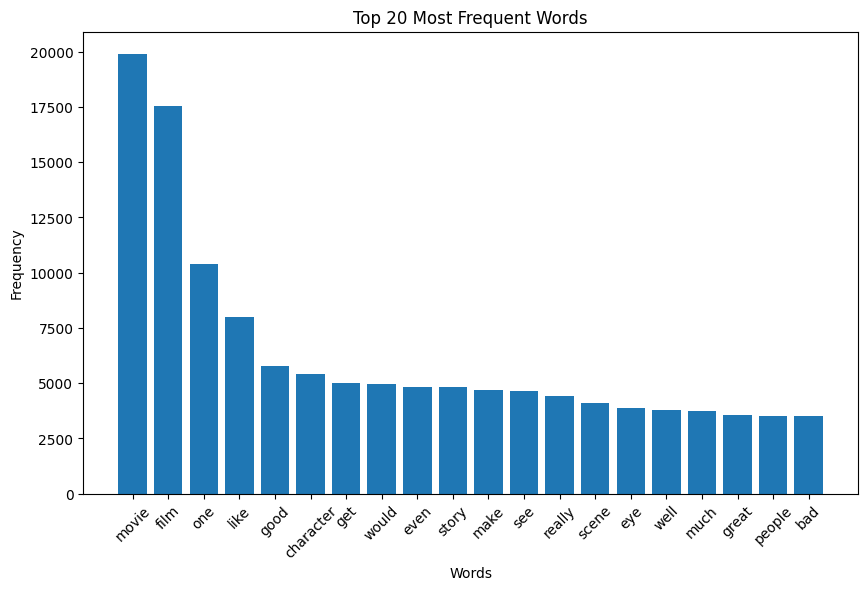


Average Document Length: 120.1477511770009
Minimum Document Length: 8
Maximum Document Length: 923


In [ ]:
dt['num_words'] = dt['lemmatized_review'].apply(lambda x: len(word_tokenize(x)))
# Compute average document length
avg_doc_length = dt['num_words'].mean()
# Compute minimum and maximum document length
min_doc_length = dt['num_words'].min()
max_doc_length = dt['num_words'].max()

# Word Frequency Analysis
# Tokenize all documents and count word frequencies
all_words = ' '.join(dt['lemmatized_review']).split()
word_freq = Counter(all_words)
# Get top 20 most frequent words
top_words = word_freq.most_common(20)

# Plotting
# Bar plot for top 20 most frequent words
plt.figure(figsize=(10, 6))
plt.bar([word[0] for word in top_words], [word[1] for word in top_words])
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Print average, minimum, and maximum document lengths
print("\nAverage Document Length:", avg_doc_length)
print("Minimum Document Length:", min_doc_length)
print("Maximum Document Length:", max_doc_length)



In [ ]:
# Filter dataset to include only positive sentiment
positive_rows = dt[dt['sentiment'] == 'positive']

# Tokenize lemmatized text in positive sentiment rows
positive_tokens = [token for row in positive_rows['lemmatized_review'] for token in row.split()]

# Count the frequency of each token
positive_word_counts = Counter(positive_tokens)

# Sort tokens based on frequency in descending order
most_common_positive_words = positive_word_counts.most_common()

# Print the top 10 most common positive words
print("Top 10 most common positive words:")
for word, count in most_common_positive_words[:10]:
    print(word, ":", count)

Top 10 most common positive words:
film : 9269
movie : 8768
one : 5363
like : 3483
good : 2853
story : 2717
character : 2673
great : 2544
see : 2481
get : 2241


In [ ]:
pip install textblob

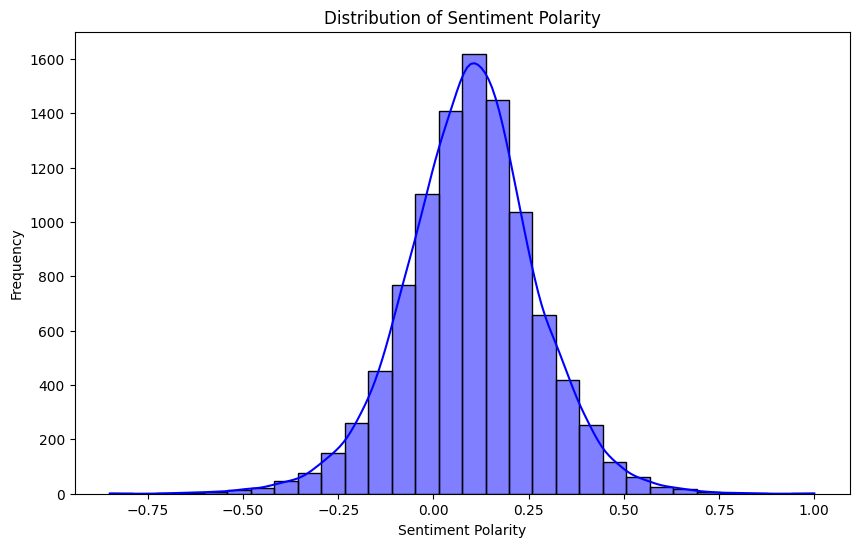

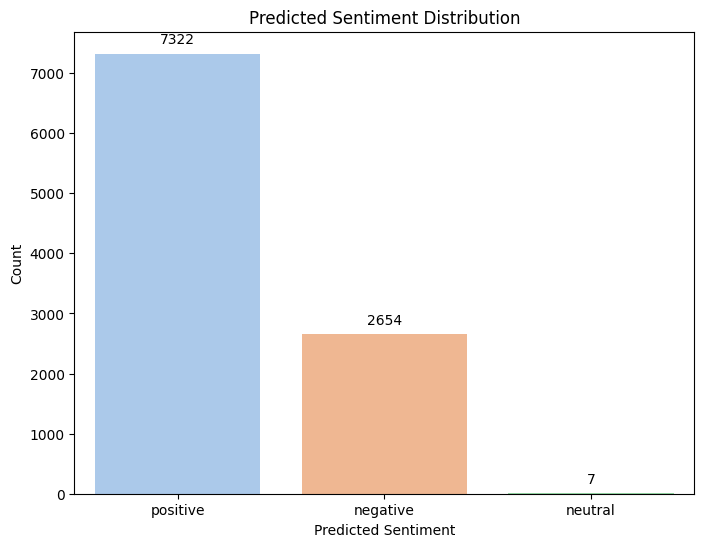

In [ ]:
from textblob import TextBlob

sentiment_df = pd.DataFrame()

# Function to calculate sentiment polarity
def get_sentiment_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply sentiment polarity analysis to the lemmatized_review column
dt['sentiment_polarity'] = dt['lemmatized_review'].apply(get_sentiment_polarity)

# Determine sentiment labels based on polarity
dt['predicted_sentiment'] = dt['sentiment_polarity'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

# Plot histogram of sentiment polarity
plt.figure(figsize=(10, 6))
sns.histplot(dt['sentiment_polarity'], bins=30, kde=True, color='blue')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Polarity')
plt.show()

# Plot count of predicted sentiment labels
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='predicted_sentiment', data=dt, palette='pastel', hue='predicted_sentiment', legend=False)

# Add count annotations to each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')

plt.xlabel('Predicted Sentiment')
plt.ylabel('Count')
plt.title('Predicted Sentiment Distribution')
plt.show()

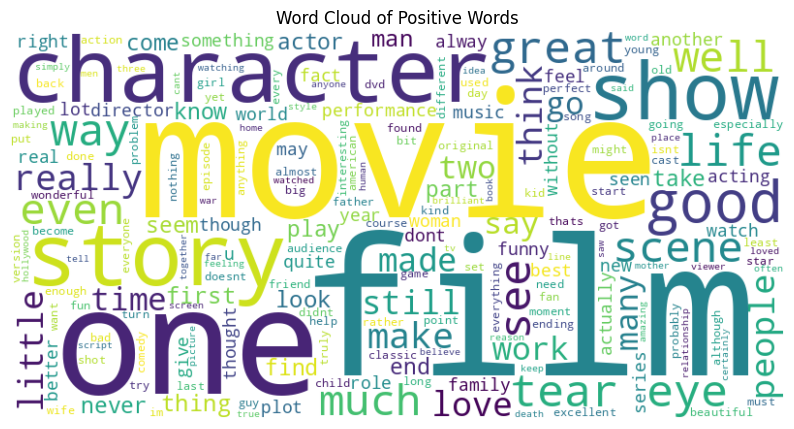

In [ ]:
from wordcloud import WordCloud

# Combine all positive tokens into a single string
positive_text = ' '.join(positive_tokens)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Words')
plt.show()

In [ ]:
# Filter dataset to include only negative sentiment
negative_rows = dt[dt['sentiment'] == 'negative']

# Tokenize lemmatized text in negative sentiment rows
negative_tokens = [token for row in negative_rows['lemmatized_review'] for token in row.split()]

# Count the frequency of each token
negative_word_counts = Counter(negative_tokens)

# Sort tokens based on frequency in descending order
most_common_negative_words = negative_word_counts.most_common()

# Print the top 10 most common negative words
print("Top 10 most common negative words:")
for word, count in most_common_negative_words[:10]:
    print(word, ":", count)

Top 10 most common negative words:
movie : 11143
film : 8282
one : 5020
like : 4505
even : 3051
good : 2931
would : 2834
bad : 2827
get : 2758
character : 2757


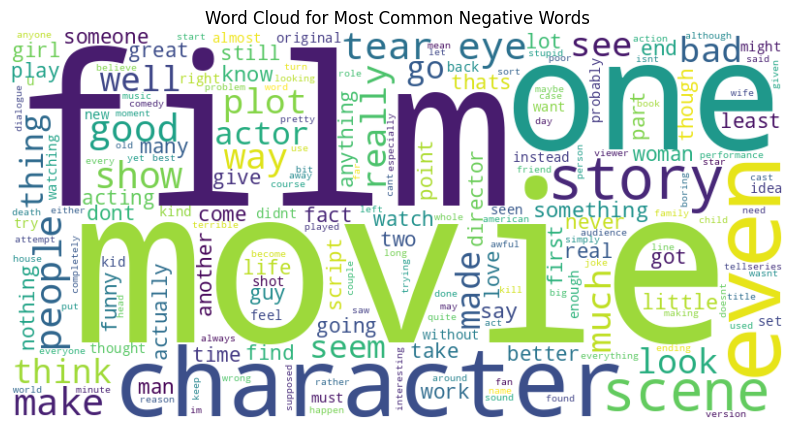

In [ ]:
from wordcloud import WordCloud

# Create a string with all negative words concatenated
negative_words_text = ' '.join(negative_tokens)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_words_text)

# Plot the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Negative Words')
plt.axis('off')
plt.show()

In [ ]:
# Function for part-of-speech tagging
def pos_tagging(text):
    return nltk.pos_tag(word_tokenize(text))

# Create a new DataFrame to store the results
Pos_dt = dt.copy()

# Apply part-of-speech tagging to the lemmatized text
Pos_dt['pos_tags'] = Pos_dt['lemmatized_review'].apply(pos_tagging)

# Display the DataFrame with part-of-speech tags
Pos_dt['pos_tags']

0       [(one, CD), (reviewer, NN), (mentioned, VBD), ...
1       [(wonderful, JJ), (little, JJ), (production, N...
2       [(thought, VBN), (wonderful, JJ), (way, NN), (...
3       [(basically, RB), (there, EX), (family, NN), (...
4       [(petter, NN), (matteis, NN), (love, VBP), (te...
                              ...                        
9995    [(fun, NN), (entertaining, VBG), (movie, NN), ...
9996    [(give, VB), (break, NN), (anyone, NN), (say, ...
9997    [(movie, NN), (bad, JJ), (movie, NN), (watchin...
9998    [(movie, NN), (probably, RB), (made, VBD), (en...
9999    [(smashing, VBG), (film, NN), (filmmaking, VBG...
Name: pos_tags, Length: 9983, dtype: object


---



---


# Modeling

Labeling the sentiment values to int, positive is 1 , negative is 0

In [ ]:
from sklearn.preprocessing import LabelEncoder

dt['sentiment'] = LabelEncoder().fit_transform(dt['sentiment'])
dt.head()

,review,sentiment,lemmatized_review
0,one reviewers mentioned watching 1 oz episode ...,1,one reviewer mentioned watching 1 oz episode y...
1,wonderful little production filming technique ...,1,wonderful little production filming technique ...
2,thought wonderful way spend tears eyes hot sum...,1,thought wonderful way spend tear eye hot summe...
3,basically theres family little boy jake thinks...,0,basically there family little boy jake think t...
4,petter matteis love tears eyes money visually ...,1,petter matteis love tear eye money visually st...


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split the data into features (X) and target variable (y)
x = dt['review']
y = dt['sentiment']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Vectorize the lemmatized text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## Random Forest Model

Random Forest Accuracy: 0.8467701552328493
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       985
           1       0.86      0.84      0.85      1012

    accuracy                           0.85      1997
   macro avg       0.85      0.85      0.85      1997
weighted avg       0.85      0.85      0.85      1997



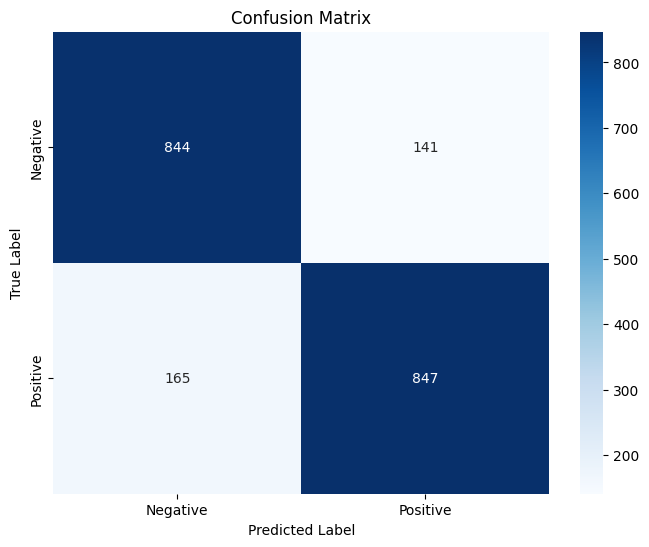

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier()

# Train the Random Forest classifier on the training data
rf_model.fit(X_train_tfidf, y_train)

# Predict sentiment labels for the test data using the trained model
rf_pred = rf_model.predict(X_test_tfidf)

# Calculate the accuracy of the Random Forest classifier
rf_accuracy = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", rf_accuracy)

# Generate a classification report to evaluate precision, recall, F1-score, and support
print("Classification Report:")
print(classification_report(y_test, rf_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, rf_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Using GridSearchCV to tune

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   3.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   3.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   3.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   3.8s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   3.8s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   7.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   6.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   7.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   6.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   8.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  13.6s
[CV] END max_depth=None, min_s

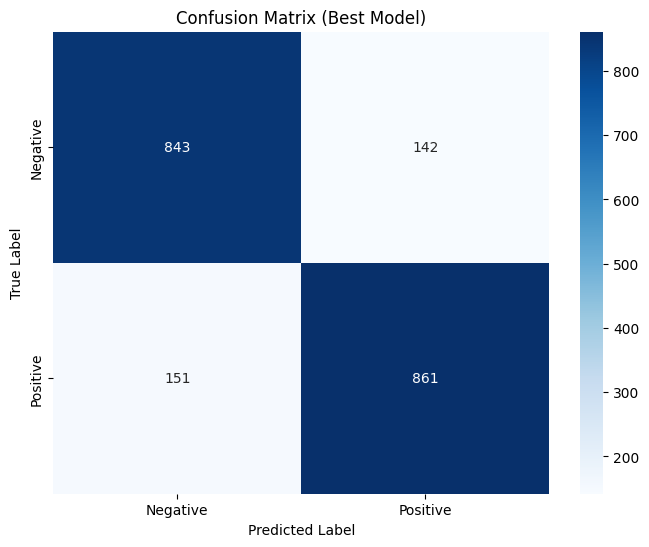

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier


# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier()

# Perform grid search
grid_search = GridSearchCV(rf_model, param_grid, cv=5,verbose = 2 ,scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Predict sentiment labels for the test data using the best model
best_model = grid_search.best_estimator_
best_pred = best_model.predict(X_test_tfidf)

# Calculate the accuracy of the best model
best_accuracy = accuracy_score(y_test, best_pred)
print("Best Model Accuracy:", best_accuracy)

# Generate classification report and confusion matrix for the best model
print("Classification Report:")
print(classification_report(y_test, best_pred))

# Compute confusion matrix
best_conf_matrix = confusion_matrix(y_test, best_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Best Model)')
plt.show()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Random Forest Accuracy: 0.8532799198798198
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       985
           1       0.86      0.85      0.85      1012

    accuracy                           0.85      1997
   macro avg       0.85      0.85      0.85      1997
weighted avg       0.85      0.85      0.85      1997



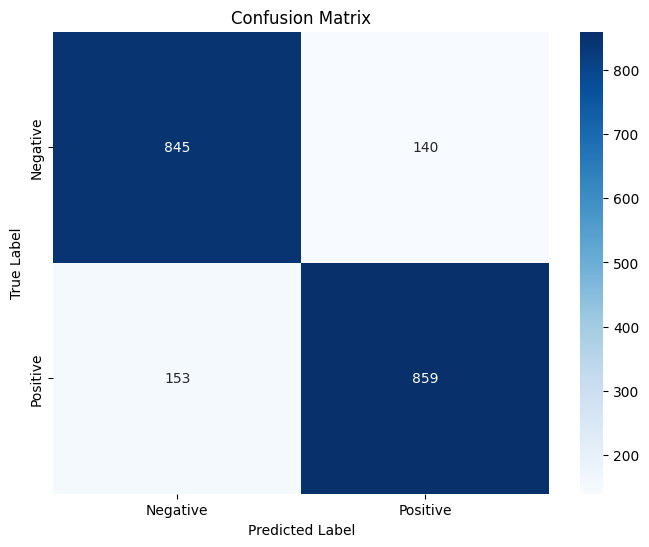

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier()

# Perform random search
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=10, cv=5, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train_tfidf, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Predict sentiment labels for the test data using the best model
best_rf_model = random_search.best_estimator_
rf_pred = best_rf_model.predict(X_test_tfidf)

# Calculate the accuracy of the best Random Forest classifier
rf_accuracy = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", rf_accuracy)

# Generate a classification report to evaluate precision, recall, F1-score, and support
print("Classification Report:")
print(classification_report(y_test, rf_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, rf_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Naive Bayes Model

Naive Bayes Accuracy: 0.8647971957936905
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       985
           1       0.88      0.85      0.86      1012

    accuracy                           0.86      1997
   macro avg       0.87      0.86      0.86      1997
weighted avg       0.87      0.86      0.86      1997



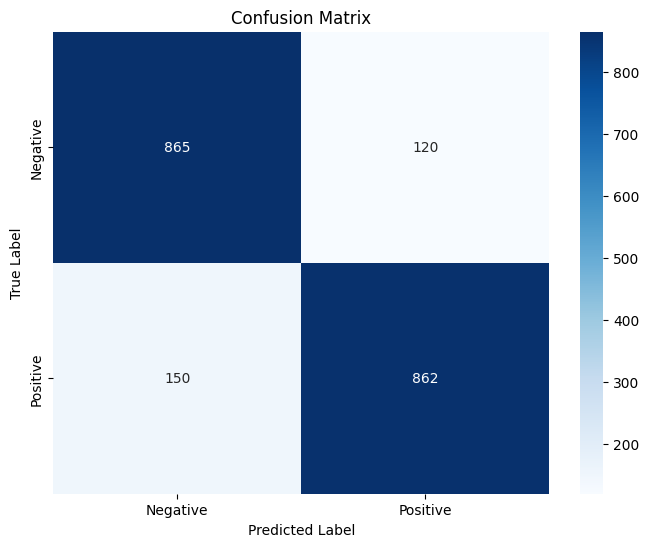

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

nb_model = MultinomialNB()

# Train the Naive Bayes classifier on the training TF-IDF data
nb_model.fit(X_train_tfidf, y_train)

# Predict sentiment labels for the test TF-IDF data using the trained model
nb_pred = nb_model.predict(X_test_tfidf)

# Calculate the accuracy of the Naive Bayes classifier
nb_accuracy = accuracy_score(y_test, nb_pred)
print("Naive Bayes Accuracy:", nb_accuracy)

# Generate a classification report to evaluate precision, recall, F1-score, and support
print("Classification Report:")
print(classification_report(y_test, nb_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, nb_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Hyperparameters: {'alpha': 2.0}
Naive Bayes Accuracy: 0.8693039559339009
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       985
           1       0.89      0.85      0.87      1012

    accuracy                           0.87      1997
   macro avg       0.87      0.87      0.87      1997
weighted avg       0.87      0.87      0.87      1997



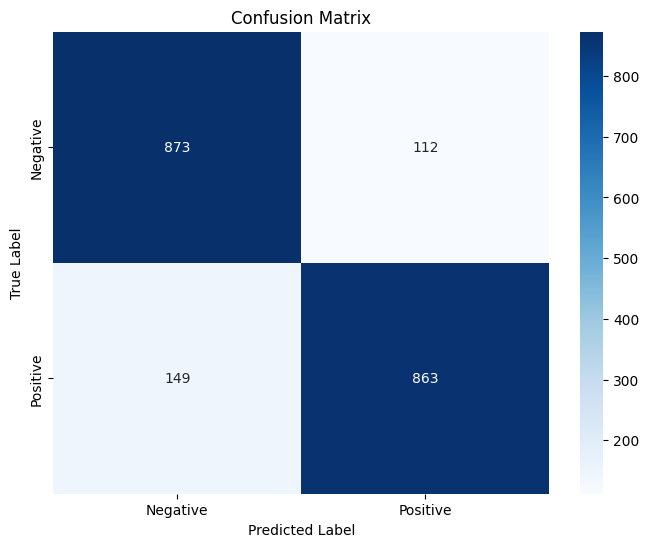

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0]  # Example values for the alpha parameter
}

# Initialize the Multinomial Naive Bayes classifier
nb_model = MultinomialNB()

# Perform grid search
grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Predict sentiment labels for the test data using the best model
best_nb_model = grid_search.best_estimator_
nb_pred = best_nb_model.predict(X_test_tfidf)

# Calculate the accuracy of the best Naive Bayes classifier
nb_accuracy = accuracy_score(y_test, nb_pred)
print("Naive Bayes Accuracy:", nb_accuracy)

# Generate a classification report to evaluate precision, recall, F1-score, and support
print("Classification Report:")
print(classification_report(y_test, nb_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, nb_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Hyperparameters: {'alpha': 2.0}
Naive Bayes Accuracy: 0.8693039559339009
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       985
           1       0.89      0.85      0.87      1012

    accuracy                           0.87      1997
   macro avg       0.87      0.87      0.87      1997
weighted avg       0.87      0.87      0.87      1997



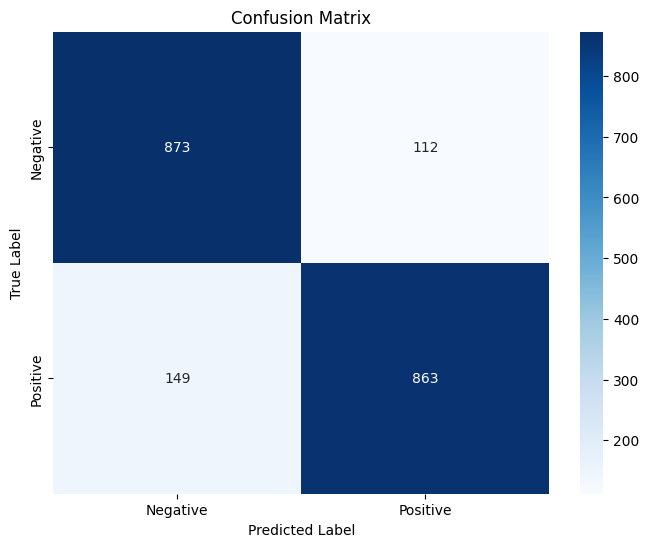

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB

# Define the hyperparameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],  # Smoothing parameter
}

# Initialize the Multinomial Naive Bayes classifier
nb_model = MultinomialNB()

# Perform random search
random_search = RandomizedSearchCV(estimator=nb_model, param_distributions=param_grid, n_iter=10, cv=5, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train_tfidf, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Predict sentiment labels for the test TF-IDF data using the best model
best_nb_model = random_search.best_estimator_
nb_pred = best_nb_model.predict(X_test_tfidf)

# Calculate the accuracy of the best Multinomial Naive Bayes classifier
nb_accuracy = accuracy_score(y_test, nb_pred)
print("Naive Bayes Accuracy:", nb_accuracy)

# Generate a classification report to evaluate precision, recall, F1-score, and support
print("Classification Report:")
print(classification_report(y_test, nb_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, nb_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## SVM

SVM Accuracy: 0.8778167250876314
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       985
           1       0.87      0.90      0.88      1012

    accuracy                           0.88      1997
   macro avg       0.88      0.88      0.88      1997
weighted avg       0.88      0.88      0.88      1997



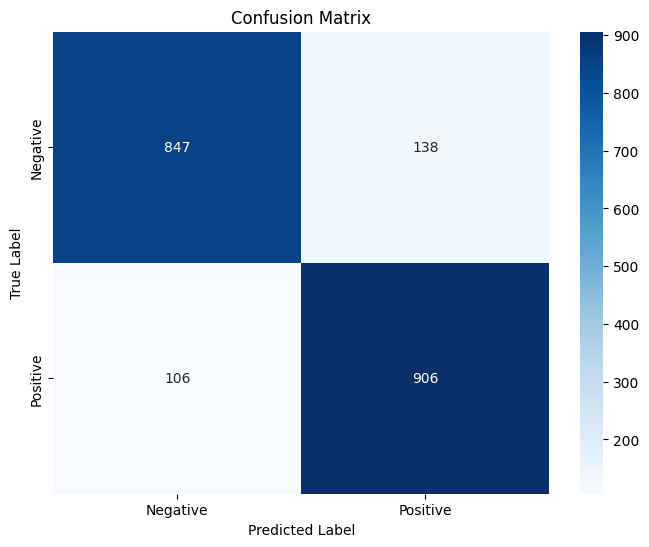

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the Support Vector Machine classifier
svm_model = SVC()

# Train the Support Vector Machine classifier on the training data
svm_model.fit(X_train_tfidf, y_train)

# Predict sentiment labels for the test data using the trained model
svm_pred = svm_model.predict(X_test_tfidf)

# Calculate the accuracy of the SVM classifier
svm_accuracy = accuracy_score(y_test, svm_pred)
print("SVM Accuracy:", svm_accuracy)

# Generate a classification report to evaluate precision, recall, F1-score, and support
print("Classification Report:")
print(classification_report(y_test, svm_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, svm_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=  37.7s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=  37.9s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=  39.6s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=  39.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=  40.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  46.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  45.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  47.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  45.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  45.7s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=  38.2s
[CV] END .....................C=0.1, gamma=1, k

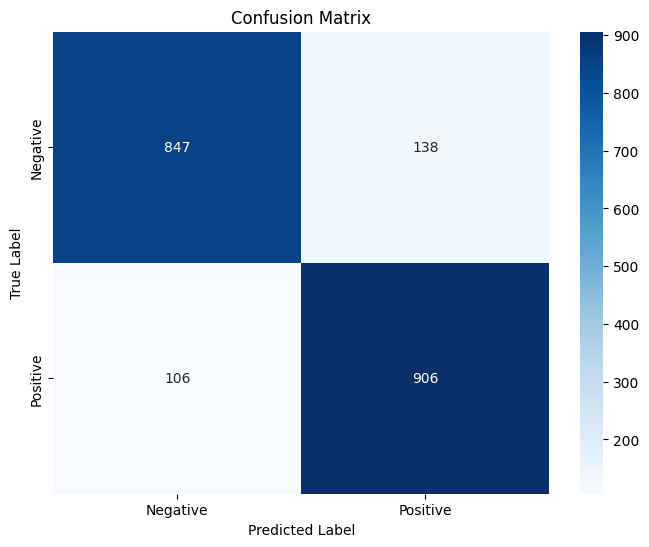

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': [1, 0.1, 0.01, 0.001],  # Kernel coefficient
    'kernel': ['linear', 'rbf', 'sigmoid']  # Kernel type
}

# Initialize the SVM classifier
svm_model = SVC()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, verbose = 2, scoring='accuracy')

# Train the GridSearchCV on the training data
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Predict sentiment labels for the test data using the best model
best_svm_model = grid_search.best_estimator_
svm_pred = best_svm_model.predict(X_test_tfidf)

# Calculate the accuracy of the best SVM classifier
best_svm_accuracy = accuracy_score(y_test, svm_pred)
print("Best SVM Accuracy:", best_svm_accuracy)

# Generate a classification report to evaluate precision, recall, F1-score, and support
print("Classification Report:")
print(classification_report(y_test, svm_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, svm_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .....................C=100, gamma=auto, kernel=poly; total time=  53.9s
[CV] END .....................C=100, gamma=auto, kernel=poly; total time=  50.5s
[CV] END .....................C=100, gamma=auto, kernel=poly; total time=  49.5s
[CV] END .....................C=100, gamma=auto, kernel=poly; total time=  50.3s
[CV] END .....................C=100, gamma=auto, kernel=poly; total time=  49.4s
[CV] END ....................C=1, gamma=auto, kernel=sigmoid; total time=  50.9s
[CV] END ....................C=1, gamma=auto, kernel=sigmoid; total time=  51.7s
[CV] END ....................C=1, gamma=auto, kernel=sigmoid; total time=  51.6s
[CV] END ....................C=1, gamma=auto, kernel=sigmoid; total time=  52.1s
[CV] END ....................C=1, gamma=auto, kernel=sigmoid; total time=  51.3s
[CV] END ..................C=100, gamma=scale, kernel=linear; total time=  26.3s
[CV] END ..................C=100, gamma=scale, k

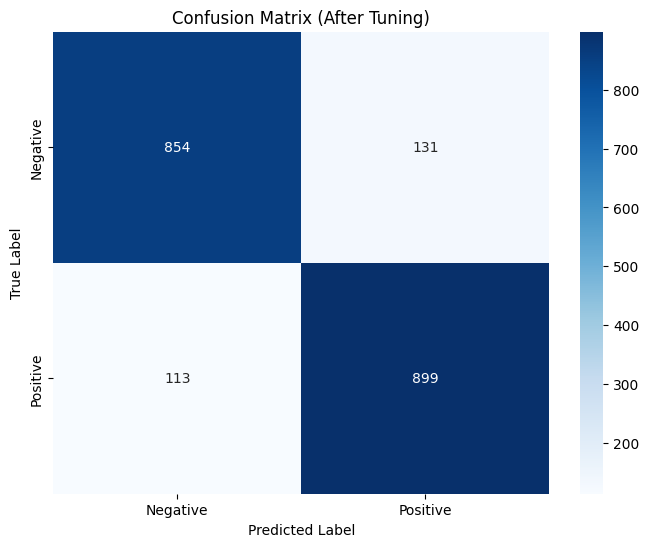

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC

# Define the parameter grid for random search
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}

# Initialize the SVM classifier
svm_model = SVC()

# Initialize RandomizedSearchCV with SVM classifier, parameter grid, and number of iterations
random_search = RandomizedSearchCV(svm_model, param_distributions=param_grid, n_iter=10, cv=5,verbose = 2, random_state=42)

# Perform random search on the training data
random_search.fit(X_train_tfidf, y_train)

# Get the best hyperparameters and corresponding model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

# Predict sentiment labels for the test data using the best model
svm_pred = best_model.predict(X_test_tfidf)

# Calculate the accuracy of the SVM classifier with tuned hyperparameters
svm_accuracy = accuracy_score(y_test, svm_pred)
print("SVM Accuracy (After Tuning):", svm_accuracy)

# Generate a classification report to evaluate precision, recall, F1-score, and support
print("Classification Report (After Tuning):")
print(classification_report(y_test, svm_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, svm_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (After Tuning)')
plt.show()